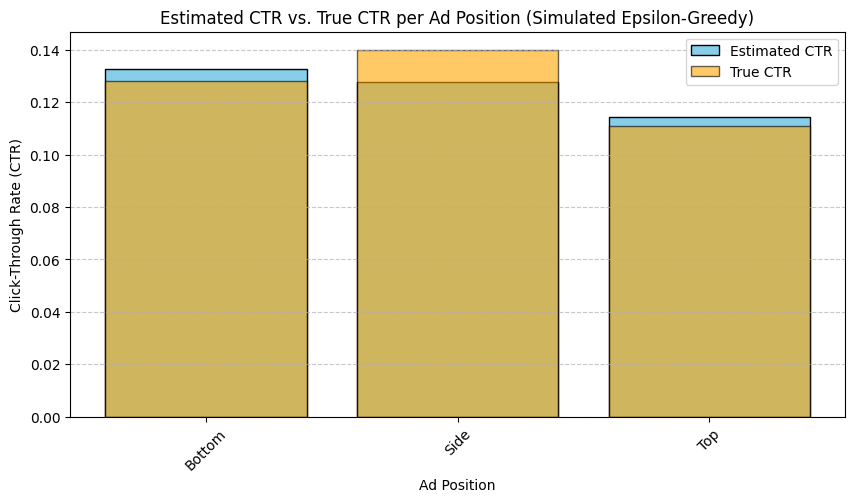

  ad_position  wins  trials       CTR  True_CTR
0      Bottom  1237    9335  0.132512  0.128062
1        Side    47     368  0.127717  0.139892
2         Top    34     297  0.114478  0.110731


In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the dataset
file_path = "cleaned_ads.csv"  # Change to actual filename
df = pd.read_csv(file_path)

# Compute true CTR for each ad position
true_ctr = df.groupby("ad_position")["click"].mean().to_dict()
ad_positions = list(true_ctr.keys())

# Initialize MAB statistics
ad_stats = {pos: {"wins": 0, "trials": 0} for pos in ad_positions}

# Simulation parameters
epsilon = 0.05  # Exploration rate
num_trials = 10000  # Total simulated user impressions

# Simulate user impressions
for _ in range(num_trials):
    # Epsilon-greedy selection of an ad position
    if random.random() < epsilon:
        chosen_ad = random.choice(ad_positions)  # Exploration
    else:
        # Exploitation: Pick ad with the highest estimated CTR
        chosen_ad = max(ad_positions, key=lambda ad: 
                        (ad_stats[ad]["wins"] + 1) / (ad_stats[ad]["trials"] + 1))  # Smoother exploitation

    # Simulate user click based on true CTR
    click = 1 if np.random.rand() < true_ctr[chosen_ad] else 0

    # Update statistics
    ad_stats[chosen_ad]["trials"] += 1
    ad_stats[chosen_ad]["wins"] += click

# Compute estimated CTRs
for pos in ad_positions:
    trials = ad_stats[pos]["trials"]
    wins = ad_stats[pos]["wins"]
    estimated_ctr = wins / trials if trials > 0 else 0
    ad_stats[pos]["CTR"] = estimated_ctr

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(ad_stats, orient="index").reset_index()
results_df.rename(columns={"index": "ad_position"}, inplace=True)

# Add true CTR for comparison
results_df["True_CTR"] = results_df["ad_position"].map(true_ctr)

# Plot Estimated CTRs vs. True CTRs
plt.figure(figsize=(10, 5))
plt.bar(results_df["ad_position"], results_df["CTR"], color='skyblue', edgecolor='black', label="Estimated CTR")
plt.bar(results_df["ad_position"], results_df["True_CTR"], color='orange', edgecolor='black', alpha=0.6, label="True CTR")
plt.xlabel("Ad Position")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("Estimated CTR vs. True CTR per Ad Position (Simulated Epsilon-Greedy)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print final results
print(results_df)


In [7]:
print(results_df)
print(df.groupby("ad_position")["click"].mean())

  ad_position  wins  trials    CTR
0         Top   174    1392  0.125
1        Side    69     552  0.125
2      Bottom   257    2056  0.125
ad_position
Bottom    0.128062
Side      0.139892
Top       0.110731
Name: click, dtype: float64


Baseline Model CTR (always Top): 0.1087
MAB Model Performance:
   ad_position  wins  trials       CTR  True_CTR
0      Bottom  1251    9406  0.133000  0.128062
1        Side    54     452  0.119469  0.139892
2         Top    17     142  0.119718  0.110731


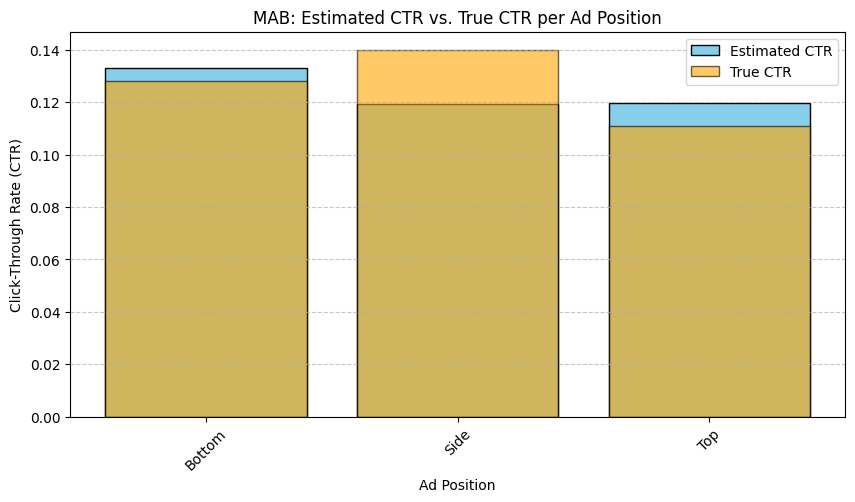

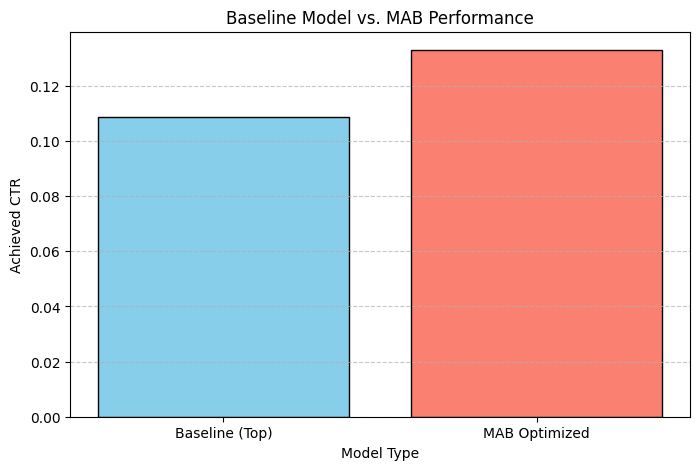

In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load dataset and get true CTRs per ad position
file_path = "cleaned_ads.csv"
df = pd.read_csv(file_path)
true_ctr = df.groupby("ad_position")["click"].mean().to_dict()

# Define ad positions
ad_positions = list(true_ctr.keys())

# Introduce randomness to simulate real-world changes
def dynamic_ctr(ad_position, timestep):
    """ Simulate seasonality and competitor influence on CTRs. """
    base_ctr = true_ctr[ad_position]

    # Seasonality effect (sine wave to fluctuate CTR)
    seasonality = 0.02 * np.sin(2 * np.pi * (timestep / 1000))

    # Competitor changes (random shifts every 2000 time steps)
    competitor_effect = 0.01 * (1 if (timestep // 2000) % 2 == 0 else -1)

    # Random fluctuations (noise)
    noise = np.random.uniform(-0.005, 0.005)

    # Compute the final fluctuating CTR, ensuring it remains valid (0 to 1)
    fluctuating_ctr = max(0, min(1, base_ctr + seasonality + competitor_effect + noise))
    return fluctuating_ctr

# Initialize statistics for MAB
ad_stats = {pos: {"wins": 0, "trials": 0} for pos in ad_positions}
baseline_stats = {"wins": 0, "trials": 0}  # Baseline model (always chooses "Top")

# Simulation parameters
epsilon = 0.05  # Exploration rate
num_trials = 10000  # Total simulated impressions

# Simulate user interactions
for t in range(num_trials):
    # Baseline model always picks "Top"
    baseline_click = 1 if np.random.rand() < dynamic_ctr("Top", t) else 0
    baseline_stats["trials"] += 1
    baseline_stats["wins"] += baseline_click

    # Epsilon-greedy selection for MAB model
    if random.random() < epsilon:
        chosen_ad = random.choice(ad_positions)  # Exploration
    else:
        # Exploitation: Pick ad with the highest estimated CTR
        chosen_ad = max(ad_positions, key=lambda ad: 
                        (ad_stats[ad]["wins"] + 1) / (ad_stats[ad]["trials"] + 1))

    # Simulate user click for chosen ad
    click = 1 if np.random.rand() < dynamic_ctr(chosen_ad, t) else 0

    # Update MAB statistics
    ad_stats[chosen_ad]["trials"] += 1
    ad_stats[chosen_ad]["wins"] += click

# Compute estimated CTRs for MAB
for pos in ad_positions:
    trials = ad_stats[pos]["trials"]
    wins = ad_stats[pos]["wins"]
    estimated_ctr = wins / trials if trials > 0 else 0
    ad_stats[pos]["CTR"] = estimated_ctr

# Compute baseline CTR
baseline_ctr = baseline_stats["wins"] / baseline_stats["trials"]

# Convert MAB results to DataFrame
results_df = pd.DataFrame.from_dict(ad_stats, orient="index").reset_index()
results_df.rename(columns={"index": "ad_position"}, inplace=True)

# Add true CTR for comparison
results_df["True_CTR"] = results_df["ad_position"].map(true_ctr)

# Print Results
print(f"Baseline Model CTR (always Top): {baseline_ctr:.4f}")
print("MAB Model Performance:\n", results_df)

# Plot Estimated CTRs vs. True CTRs for MAB
plt.figure(figsize=(10, 5))
plt.bar(results_df["ad_position"], results_df["CTR"], color='skyblue', edgecolor='black', label="Estimated CTR")
plt.bar(results_df["ad_position"], results_df["True_CTR"], color='orange', edgecolor='black', alpha=0.6, label="True CTR")
plt.xlabel("Ad Position")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("MAB: Estimated CTR vs. True CTR per Ad Position")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Compare Baseline vs. MAB Performance
plt.figure(figsize=(8, 5))
plt.bar(["Baseline (Top)", "MAB Optimized"], [baseline_ctr, results_df["CTR"].max()], color=['salmon', 'skyblue'], edgecolor='black')
plt.xlabel("Model Type")
plt.ylabel("Achieved CTR")
plt.title("Baseline Model vs. MAB Performance")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
